# Lab session of 31/05/2023

## Problem 1: CVRP

The Capacitated Vehicle Routing Problem (CVRP) is a generalization of the Traveling Salesman Problem (TSP) where a fleet of vehicles $K$ is available to serve a set of customers. Each vehicle has a limited capacity and the goal is to find a set of routes that minimizes the total travel cost while serving all customers and respecting the capacity constraint of each vehicle.

In particulat, let $G = (V, A)$ be a complete graph, where $V = \{0,...,n\}$ is the vertex set and $A$ is the arc set. Vertices $i = 1,...,n$ correspond to the customers, whereas vertex $0$ corresponds to the depot. A nonnegative cost, $c_{ij}$, is associated with each arc $(i,j) \in A$ and represents the travel cost spent to go from vertex $i$ to vertex $j$. We suppose that $c_{ii} = \infty$ for all $i \in V$.

Each customer $i \in V$ is associated with a known nonnegative demand to be delivered, $d_i$, and the depot has a fictitious demand $d_0 = 0$. 

A set $K$ of identical vehicles, each with capacity $C$, is available at the depot. To ensure feasibility we assume that $d_i \le C$ for each $i \in V$ and that we have a sufficient amount of vehicles to serve all customers.

Given a vertex set $S \subseteq V \setminus \{0\}$, let $d(S) = \sum_{i \in S}{d_i}$ denote the total demand of the set. We denote with $r(S)$ the minimum number of vehicles needed to serve the total demand of $S$, i.e., $r(S) = \lceil d(S)/C \rceil$.

The CVRP consists of finding a collection of vehicle routes with minimum cost, defined as the sum of the costs of the arcs belonging to each route, and such that:
* each route starts and finishes at the depot vertex;
* each customer vertex is visited by exactly one route; 
* the sum of the demands of the vertices visited by a route does not exceed the vehicle's capacity $C$.

## Clarke and Wright Savings Algorithm

1.   Calculate the savings $s_{ij} = c_{0i} + c_{0j} - c_{ij}$ for every pair $(i,j) \in V$.
2.   Sort the savings $s_{ij}$ and list them in descending order.
3.   For each saving $s_{ij}$, include link $(i,j)$ in a route if no route constraints will be violated through the inclusion of $(i,j)$ in a route, and if either one of these 3 conditions hold:
    1. Neither i nor j have already been assigned to a route, in which case a new route is initiated including both i and j. 
    2. Exactly one of the two nodes (i or j) has already been included in an existing route and that point is not interior to that route (a point is interior to a route if it is not adjacent to the depot D in the order of traversal of nodes), in which case the link (i, j) is added to that same route.
    3. Both i and j have already been included in two different existing routes and neither point is interior to its route, in which case the two routes are merged.

4.   If the savings list $s_{ij}$ has not been exhausted, return to Step 3, processing the next entry in the list; otherwise, stop: the solution to the VRP consists of the routes created during Step 3. 

(Any nodes that have not been assigned to a route during Step 3 must each be served by a vehicle route that begins at the depot D visits the unassigned point and returns to D.)

In [18]:
import numpy as np
import math

n = 8       # number of nodes
max_d = 10  # max demand per node
C = 30      # capacity of each vehicle

grid_size = 100 # size of the grid of points

np.random.seed(1337)

# Create k random points with two coordinates. Multiplying by grid_size yields
# random numbers between 0 and 100.
point = grid_size * np.random.random((n,2))

d = np.random.choice(np.arange(1, max_d), size=n)

k = int(np.ceil(np.sum(d) / C))

K = [i for i in range(k)]

# Define the set of vertices of the graph as the list of numbers from 0 to k-1
V = [i for i in range(n)]

# Determine the distance between each point
c = np.array([[math.sqrt(np.sum((point[i] - point[j])**2)) for i in V] for j in V])

# Set C[i,i] to an arbitrarily large value to forbid usage of x[i,i]
for i in V:
  c[i,i] = 10000000

print(n)
print(C)
print(k)
print(k)

8
30
2
2


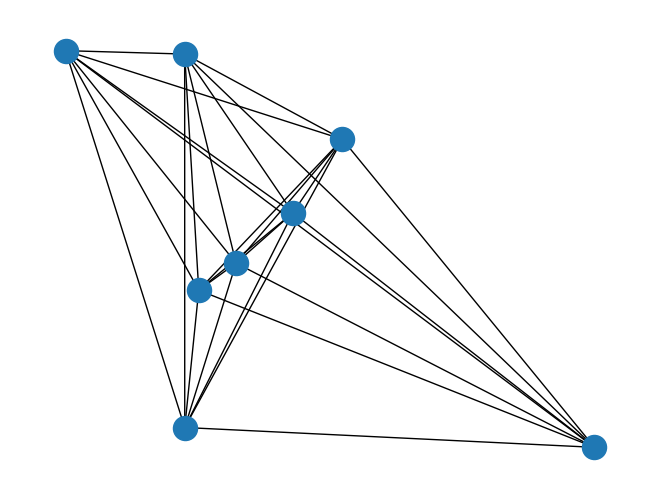

In [19]:
import networkx as nx

# Set of arcs
E = [(i,j) for i in V for j in V if i < j]

# Define a dictionary whose keys are the nodes, and the values are tuples
# containing the (x,y) coordinates of each point
coord = {i: (point[i,0], point[i,1]) for i in V}

g = nx.Graph()

g.add_nodes_from(V)
g.add_edges_from(E)

nx.draw(g, pos=coord)

In [20]:
# STEP 1. Calculate savings for each pair (i,j) in V (depot excluded). Store them in a dict.
s = {}
for (i,j) in E:
  if i == 0 or j == 0:
    continue
  s[(i,j)] = c[0,i] + c[0,j] - c[i,j]


# STEP 2. Sort savings in descending order
s = sorted(s.items(),key=lambda x:x[1], reverse=True)  

In [21]:
# utility function used to check if a route (list of int [0, v1, v2, ..., 0])
# respects capacity constraints
def is_capacity_feasible(route, C):
  return sum(d[i] for i in route) <= C

def is_interior(node, route):
  idx = route.index(node) # get position of node inside route
  # if it is interior if not first or last (depot excluded)
  return idx > 1 and idx < len(route) - 2

def merge(first_route, second_route):
  # removes depot return from first_route (from [0, v1, v2, 0] to [0, v1, v2])
  first = first_route[:-1]
  # removes depot start from second_route (from [0, v1, v2, 0] to [v1, v2, 0])
  second = second_route[1:]
  return first + second


# STEP 3. Process all savings one by one starting from the biggest.

# Here we will store our routes
routes = []

# List of unassigned customers
unassigned = set([i for i in V if i != 0])

for sav in s:
  i,j = sav[0]

  # Case 1: neither i or j have been assigned to a route
  if i in unassigned and j in unassigned:
    route = [0, i, j, 0]
    if is_capacity_feasible(route, C):
      routes.append(route)

    unassigned.remove(i)
    unassigned.remove(j)

  # Case 2: one between i and j is not assigned to a route
  elif i in unassigned or j in unassigned:
    # track which between i and j is in a route
    in_route = i
    out_route = j
    if i in unassigned:
      in_route = j
      out_route = i

    # Find the route (copy the route to modify it without altering the original
    # one, the index is stored for updating it later.)
    route = None
    route_idx = None
    for idx, r in enumerate(routes):
      if in_route in r:
        route = r.copy()
        route_idx = idx
        break
    
    # check if in_route is interior for route
    if not is_interior(in_route, route):
      idx = route.index(in_route)
      if idx == 1:
        route.insert(1, out_route)
      elif idx == len(route) - 2:
        route.insert(len(route) - 2, out_route)
      else:
        raise ValueError('Something went wrong')

      if is_capacity_feasible(route, C):
        routes[route_idx] = route
        unassigned.remove(out_route)

  # Case 3: both i and j are assigned to a route
  else:
    # merge routes eventually
    route_i, route_j = None, None
    for idx, r in enumerate(routes):
      if i in r:
        route_i = r
      if j in r:
        route_j = r

    if not (is_interior(i, route_i) or is_interior(j, route_j)):
      idx_i = route_i.index(i)
      idx_j = route_j.index(j)

      route = None
      if idx_i >= len(route_i) - 2 and idx_j <= 1:
        route = merge(route_i, route_j)
      elif idx_i >= len(route_i) - 2 and idx_j >= len(route_j) - 2:
        route = merge(route_i, route_j[::-1])
      elif idx_i <= 1 and idx_j >= len(route_j) - 2:
        route = merge(route_j, route_i)
      elif idx_i <= 1 and idx_j <= 1:
        route = merge(route_i[::-1], route_j)
      else:
        raise ValueError("Something went wrong")

      if is_capacity_feasible(route, C):
        routes.append(route)
        routes.remove(route_i)
        routes.remove(route_j)


obj = 0
for route in routes:
  print(route)
  for k in range(len(route)):
    if k == 0:
      continue
    obj += c[route[k-1], route[k]]

print(obj)

[0, 1, 2, 7, 3, 6, 0]
[0, 4, 5, 0]
348.2873363587437


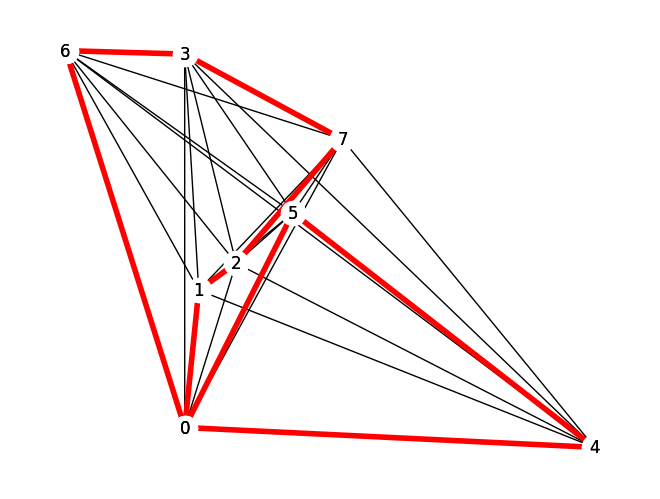

In [22]:
def draw_solution(V, A, routes):
    g = nx.Graph()

    # Draw the whole graph first: all nodes, all arcs, no highlighting
    g.add_nodes_from(V)
    g.add_edges_from([(i,j) for (i,j) in A])
    nx.draw(g, pos=coord, with_labels=True, node_color="white")

    # Reset the graph and add only the arcs that belong to the solution, 
    # i.e. those for which the optimal value of the variable x[i,j] is nonzero
    g.clear()

    route_edges = []
    for r in routes:
      for k in range(len(r)):
        if k == 0:
          continue
        route_edges.append((r[k-1], r[k]))

    g.add_edges_from(route_edges)
    nx.draw(g, pos=coord, width=4, edge_color='red', with_labels=True, node_color='white')

    # finally, draw a graph consisting of the sole root node, highlighted in green
    g.clear()
    g.add_node(0)
    nx.draw(g, pos={0: coord[0]}, node_color='white', with_labels=True)

draw_solution(V, E, routes)